In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Metric
import matplotlib.pyplot as plt

In [41]:
VOCAB_SIZE = 20000
ENGLISH_SEQUENCE_LENGTH = 64
FRENCH_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 300
BATCH_SIZE=8

## Data Preparation

In [3]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2023-07-15 14:45:46--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7420323 (7.1M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   7.08M  18.9MB/s    in 0.4s    

2023-07-15 14:45:47 (18.9 MB/s) - ‘fra-eng.zip.1’ saved [7420323/7420323]



In [4]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
replace /content/dataset/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/dataset/_about.txt  
replace /content/dataset/fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/dataset/fra.txt  


In [13]:
!wc -l /content/dataset/fra.txt

217975 /content/dataset/fra.txt


In [5]:
!head -1000 /content/dataset/fra.txt > /content/dataset/fra_1000.txt

## Preprocessing

In [6]:
text_dataset = tf.data.TextLineDataset("/content/dataset/fra_1000.txt")
text_dataset

<TextLineDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [8]:
# find the longest sequence
for i in text_dataset.skip(190000):
    print(len(tf.strings.split(i, " ")))

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization?hl=en

Maps text features to integer sequences

In [9]:
english_vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [10]:
french_vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

![](https://d2l.ai/_images/seq2seq.svg)

From the file, we will select english(input1), french(input2), french(output)

In [11]:
def selector(input_text):
  split_text = tf.strings.split(input_text, '\t')
  return {'input_1':split_text[0:1], 'input_2': '[start] ' + split_text[1:2]}, split_text[1:2]+' [end]'
  # {english, french(with start)}, french(with end)

In [12]:
split_dataset = text_dataset.map(selector)

In [13]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! [end]'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. [end]'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! [end]'], dtype=object)>)


Separating to english(x) and french(y) dataset to make a separate vectorizer for each language. This process is to **include [start], [end] tokens in the vectorizer layer**. (With the previous selector function, start/end token is serparate so one of the tokens will be excluded when creating vectorizer)

In [14]:
def separator(input_text):
  split_text = tf.strings.split(input_text, '\t')
  return split_text[0:1], '[start] ' + split_text[1:2]+' [end]'

In [15]:
init_dataset = text_dataset.map(separator)

In [16]:
for i in init_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] Va ! [end]'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] Marche. [end]'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] En route ! [end]'], dtype=object)>)


In [18]:
english_training_data = init_dataset.map(lambda x,y : x) # input x,y and output x # only for english
english_vectorize_layer.adapt(english_training_data)

In [19]:
# check the vectorize layer
english_vectorize_layer.get_vocabulary()[10]

'tom'

In [20]:
french_training_data = init_dataset.map(lambda x,y : y) # input x,y and output x # only for english
french_vectorize_layer.adapt(french_training_data)

Coming back to split_dataset created with selector function.

In [21]:
def vectorizer(inputs, output):
  return {'input_1' :english_vectorize_layer(inputs['input_1']),
          'input_2': french_vectorize_layer(inputs['input_2'])}, french_vectorize_layer(output)

In [22]:
dataset = split_dataset.map(vectorizer)

In [30]:
# check if each inputs are mapped with the adapted vectorizer
for i in dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[ 2, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[12,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>)
({'input_1': <tf.Tensor: shape

### Batch/Split

In [23]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
NUM_BATCHES=int(1000/BATCH_SIZE)
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

## Modeling

![](https://d2l.ai/_images/seq2seq.svg)

Seq2seq structure

In [24]:
NUM_UNITS = 256

In [25]:
## ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype="int64", name="input_1") # (BS, 64)
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM, )(input)
encoded_input = Bidirectional(GRU(NUM_UNITS),)(x)

## DECODER
shifted_target = Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype="int64", name="input_2")
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM,)(shifted_target)

x = GRU(NUM_UNITS*2, return_sequences=True)(x, initial_state=encoded_input)

## OUTPUT
x = Dropout(0.5)(x) # reduce overfitting
target = Dense(VOCAB_SIZE, activation="softmax")(x)
seq2seq_gru = Model([input, shifted_target], target)

#### DECODER
- Why NUM_UNITS*2?
  - Bidirectional layer makes 2 vectors concatenated
- Why return_sequences=True in DECODER GRU?
  - Need the outputs of GRU cell (no need in ENCODER)

#### OUTPUT
- Why VOCAB_SIZE in Dense layer?
  - returned sequence of the GRU cell -> 512 dimension
  - output of GRU layer -> (B, sequence_length, 512)
  - we want to choose one word out of 20000 words (VOCAB_SIZE)
  - So, (B, seq_len, 512) -> (B, seq_len, VOCAB_SIZE)

In [26]:
seq2seq_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 64, 300)      6000000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 64, 300)      6000000     ['input_2[0][0]']                
                                                                                              

https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

- Use this crossentropy loss function when there are **two or more label classes**. We expect labels to be provided as **integers**.
- If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss.

In [27]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [28]:
history = seq2seq_gru.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3
112/112 [==============================] - 19s 82ms/step - loss: 4.1905 - accuracy: 0.9191 - val_loss: 0.4121 - val_accuracy: 0.9534
Epoch 2/3
112/112 [==============================] - 5s 46ms/step - loss: 0.3758 - accuracy: 0.9542 - val_loss: 0.3242 - val_accuracy: 0.9555
Epoch 3/3
112/112 [==============================] - 5s 41ms/step - loss: 0.3137 - accuracy: 0.9546 - val_loss: 0.2833 - val_accuracy: 0.9551


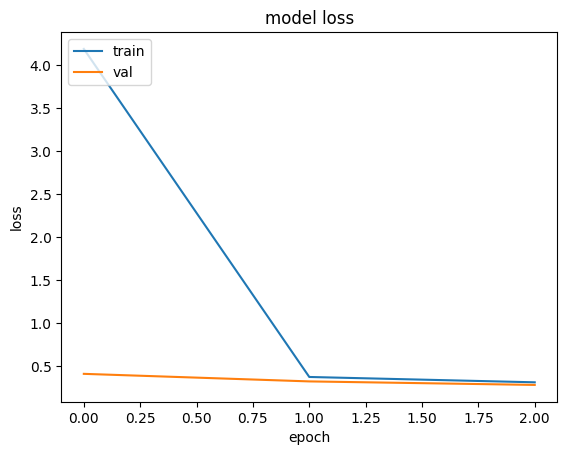

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

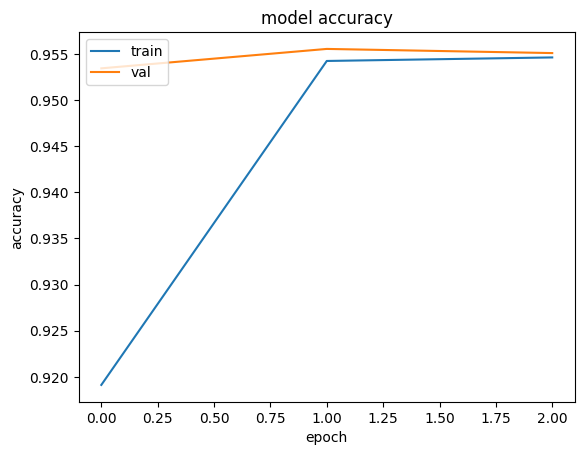

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## BLEU Score
https://wikidocs.net/31695
- Accuracy is not enough
- Bilingual Evaluation Understudy
- \# of predicted words that are in the target / predicted word
- If same word is repeated, it does not count.
- compute on ngrams (check if the word matches within the window)
- Brevity penalty: Penalize the short output, give higher score to longer output

In [45]:
class BLEU(Metric):
  def __init__(self, name='bleu_score'):
    super(BLEU, self).__init__()
    self.bleu_score = 0

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.argmax(y_pred, axis=-1) # one-hot into vectorized form
    self.bleu_score = 0

    batch_score = []
    for pred_sample, true_sample in zip(y_pred, y_true): # loop through batches
      tf.autograph.experimental.set_loop_options()
      num_words_pred = tf.math.count_nonzero(pred_sample)

      total_matches = 0
      # check every element in y_pred if it is in y_true => +1
      for word in pred_sample:
        if word == 0:
          break
        for i in range(len(true_sample)): # check for each in y_true
          if true_sample[i] == 0:
            break
          if true_sample[i] == word:
            total_matches += 1
            true_sample = tf.boolean_mask(true_sample, [False if y==i else True for y in range(len(true_sample))]) # exclude the matched component -> preventing matching again
            break

        self.bleu_score += total_matches / num_words_pred
  ## need brevity penalty

  def result(self):
    return self.bleu_score / BATCH_SIZE

tf.boolean_mask => eliminate particular element

In [46]:
j = tf.constant([2,3,4,5,0,0])
j = tf.boolean_mask(j, [False if y==2 else True for y in range(len(j))])
print(j)

tf.Tensor([2 3 5 0 0], shape=(5,), dtype=int32)


In [47]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[BLEU()],
    run_eagerly=True
)

In [48]:
history = seq2seq_gru.fit(train_dataset, epochs=3, validation_data=val_dataset) # small data

Epoch 1/3


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
112/112 [==============================] - 85s 303ms/step - loss: 0.2794 - bleu_4: 1.0000 - val_loss: 0.2598 - val_bleu_4: 1.0000
Epoch 2/3
112/112 [==============================] - 33s 290ms/step - loss: 0.2488 - bleu_4: 1.0000 - val_loss: 0.2502 - val_bleu_4: 1.0000
Epoch 3/3
112/112 [==============================] - 38s 335ms/step - loss: 0.2235 - bleu_4: 0.6146 - val_loss: 0.2083 - val_bleu_4: 0.8500
